In [51]:
%pip install pandas matplotlib scipy seaborn

Note: you may need to restart the kernel to use updated packages.


In [52]:
import os
import argparse
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
import seaborn as sns
import glob
from scipy import stats
from dateutil import tz

In [53]:
from scipy.signal import savgol_filter

from common import combine_csvs

In [54]:
MEGAb_TO_b = 1e6
TCP_DOWN = "*down.*.csv"
UDP_DOWN = "*down*udp*.csv"
TCP_UP = "*receive.*[!p].csv"
UDP_UP = "*receive*.udp.csv"
TEMP='Temp (°C)'
PRECIP='Precip. Amount (mm)'

JITTER = 'jitter_ms'
BANDWIDTH = 'bandwidth'

In [55]:
#matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
sns.set_context("paper", rc={"font.size":9,"axes.titlesize":9,"axes.labelsize":8, "xtick.labelsize":8})

In [56]:
def convert_to_mb(df):
    # Converts to Megabits per second
    df.bits_per_second /= MEGAb_TO_b
    df.rename(columns={'bits_per_second': 'bandwidth'}, inplace=True)

In [62]:
def concat_df(src, pattern, keep=['bandwidth']):
    files = glob.glob(f"{src}/**/{pattern}", recursive=True)
    combined_df = combine_csvs(files)
    
    combined_df.index = pd.to_datetime(combined_df.index, unit='s')
    convert_to_mb(combined_df)
    combined_df = combined_df[keep]
    return combined_df

In [58]:
def remove_first_measures(df, first=3):
    # Remove first {first} datapoints for each measurement
    # Take into account of software tool overhead
    diff_time = (df.index - df.reset_index().timestamp.shift())
    # Choose entries where previous time is less than an hour
    first_measure_map = diff_time < pd.Timedelta(5, unit='m')
    # Propagate to first three datapoints
    for i in range(1, first):
        first_measure_map = first_measure_map.eq(first_measure_map.shift(i))

    df_map = pd.DataFrame(columns=df.columns)
    df_map.iloc[:,0] = first_measure_map
    df_map['timestamp'] = df.index
    df_map.set_index('timestamp', inplace=True)
    filtered_df = df.where(df_map, -1) # Set to -1

    return filtered_df

In [123]:
def combine_reg(src, pattern, keep='bandwidth', first=3):
    regions_df = pd.DataFrame()
    start = True
    for region in glob.glob(f"{src}/*"):
        combined_df = concat_df(region, pattern, [keep]).sort_values('timestamp')
        reg_name = os.path.basename(region)
        combined_df.rename(columns={keep: reg_name}, inplace=True)
        combined_df = remove_first_measures(combined_df, first)

        if start:
            regions_df = combined_df
            start = False
        else:
            regions_df = pd.merge(regions_df, combined_df, how='outer', left_index=True, right_index=True)

    return regions_df

In [141]:
src_dirs = [('Starlink', 'data/Starlink_csv_2022_04-07_to_04-12/')]

In [142]:
df = pd.DataFrame()
for type_name, folder in src_dirs:
    #df = concat_df(args.src_folder, UDP_UP, [JITTER])
    df_temp = combine_reg(folder, UDP_DOWN, first=1)
    df = df.merge(df_temp, how='outer', left_index=True, right_index=True)
df

,Asia_Pacific_Sydney,US_West_N_California
timestamp,,
2022-04-09 05:01:12.000000000,-1.000000,NaN
2022-04-09 05:01:13.000016896,260.903149,NaN
2022-04-09 05:01:14.000073984,256.442956,NaN
2022-04-09 05:01:15.000043008,259.786129,NaN
2022-04-09 05:01:16.000029952,271.408526,NaN
...,...,...
2022-04-12 16:02:44.000000000,NaN,-1.000000
2022-04-12 16:02:45.000081920,NaN,204.466942
2022-04-12 16:02:46.000092928,NaN,195.307927


In [ ]:
df_unstacked = df.unstack().dropna()
df_unstacked = df_unstacked.mask(df_unstacked == -1).reset_index(name=BANDWIDTH).set_index('timestamp')

df_unstacked

In [143]:
df_regs = df.replace(-1, pd.NA)
df_regs = df_regs.dropna(how='all').astype(float)
#df = concat_df(args.src_folder, UDP_DOWN).sort_values('timestamp')
#df_regs = df_regs.loc['2022-05-28 18:13:00':]
#df = df.loc['2022-03-01 04:07:30':'2022-03-01 04:08:40']
#df = df.loc['2022-03-01':'2022-03-02']

df_regs

,Asia_Pacific_Sydney,US_West_N_California
timestamp,,
2022-04-09 05:01:13.000016896,260.903149,NaN
2022-04-09 05:01:14.000073984,256.442956,NaN
2022-04-09 05:01:15.000043008,259.786129,NaN
2022-04-09 05:01:16.000029952,271.408526,NaN
2022-04-09 05:01:37.000055040,NaN,262.316303
...,...,...
2022-04-12 16:02:24.000078080,237.280050,NaN
2022-04-12 16:02:45.000081920,NaN,204.466942
2022-04-12 16:02:46.000092928,NaN,195.307927


In [149]:
# Aggreagation options
df_regs_interp = df_regs
df_regs_interp = df_regs_interp.resample('T').mean()
df_regs_interp = df_regs_interp.interpolate(method='linear')
df_regs_interp = df_regs_interp.apply(lambda x: savgol_filter(x,41,1))
# Perform savgol filtering
df_regs_interp

#df.to_csv("out.csv", encoding='utf-8-sig')


,Asia_Pacific_Sydney,US_West_N_California
timestamp,,
2022-04-09 05:01:00,265.570646,231.189323
2022-04-09 05:02:00,266.652414,230.514682
2022-04-09 05:03:00,267.734182,229.840040
2022-04-09 05:04:00,268.815950,229.165399
2022-04-09 05:05:00,269.897718,228.490757
...,...,...
2022-04-12 15:58:00,246.777955,205.383897
2022-04-12 15:59:00,246.596301,205.202528
2022-04-12 16:00:00,246.414647,205.021158


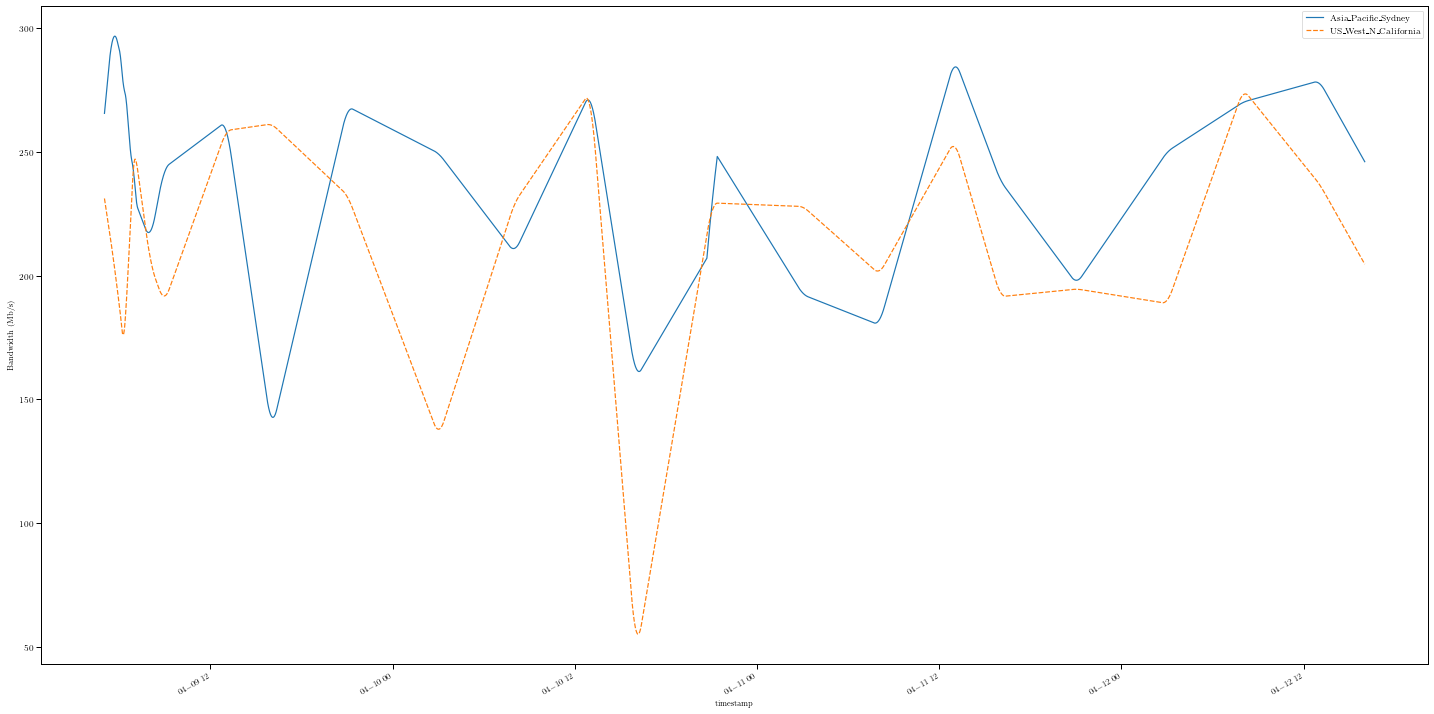

In [150]:
#fig, ax = plt.subplots(figsize=(3.5,3))
fig, ax = plt.subplots(figsize=(20,10))

ax.xaxis.update_units(df.index)
y_val = df_unstacked.bandwidth
#sns.scatterplot(x=ax.xaxis.convert_units(df.timestamp), y=y_val, ax=ax)
#sns.jointplot(x=ax.xaxis.convert_units(df.timestamp), y=y_val, ax=ax)

#sns.lineplot(x=ax.xaxis.convert_units(df.index), y=y_val, ax=ax, hue=y_val.isna().cumsum(),
#        palette=["black"]*sum(y_val.isna()), markers=True, legend=False)
#sns.lineplot(data=df_regs)
g = sns.lineplot(data=df_regs_interp)
#ax.set(yscale='log')
g.figure.autofmt_xdate()

#ax.set_ylabel("Jitter (ms)")
ax.set_ylabel("Bandwidth (Mb/s)")
fig.tight_layout()

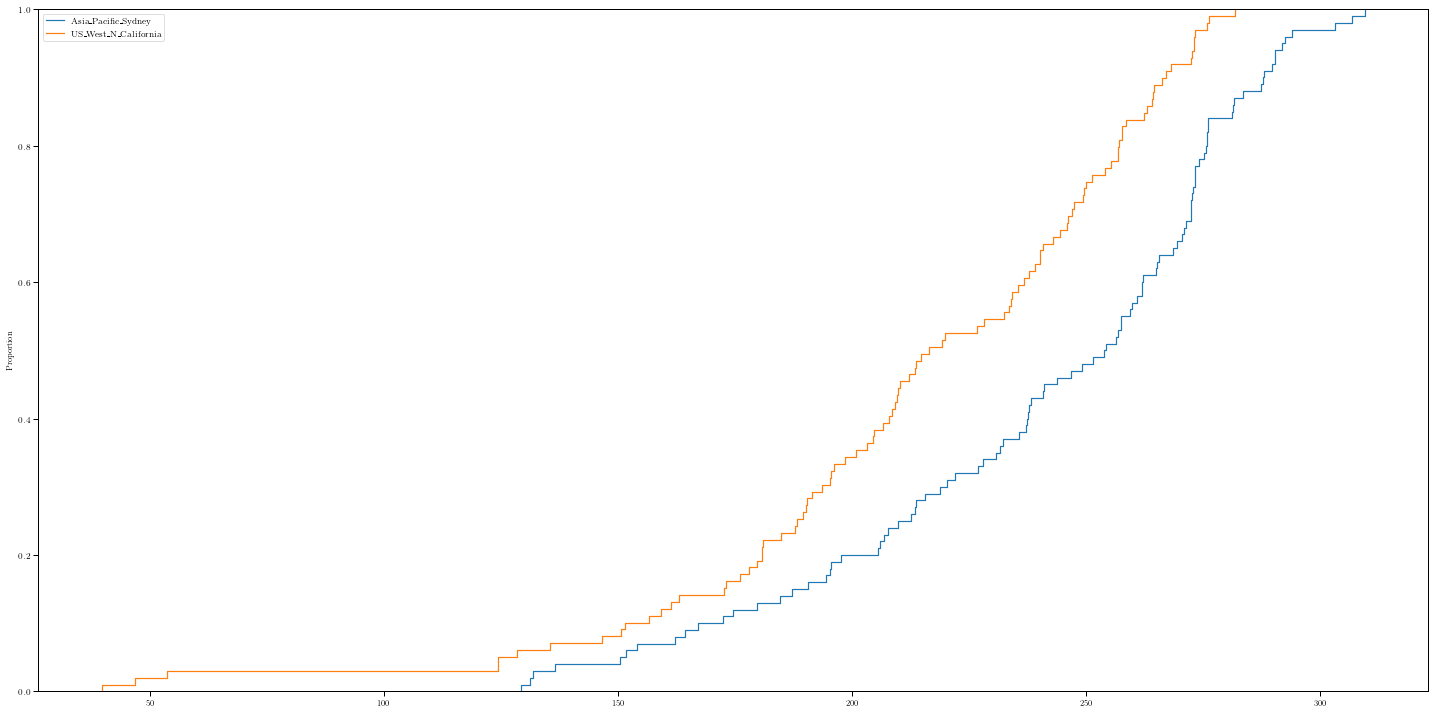

In [148]:
fig2, ax2 = plt.subplots(figsize=(20,10))
sns.ecdfplot(data=df_regs)
fig2.tight_layout()

In [151]:
fig.savefig(f'output/throughput/throughput.png', bbox_inches='tight')
fig2.savefig(f'output/throughput/throughput_cdf.png', bbox_inches='tight')